In [ ]:
!pip install osmium
!pip install networkx
!pip install torch
!pip install torch-geometric
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
import osmium
import networkx as nx
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import random
import json
import math
import matplotlib.pyplot as plt
import h5py
import pickle
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
)



In [ ]:
#Parse OSM File and Build Graph
from google.colab import drive
drive.mount("/content/drive")



class OSMHandler(osmium.SimpleHandler):
    def __init__(self):
        super().__init__()
        self.nodes = {}   # key: node id, value: (lat, lon)
        self.edges = []   # list of (source, target) edges

    def node(self, n):
        self.nodes[n.id] = (n.location.lat, n.location.lon)

    def way(self, w):
        if len(w.nodes) >= 2:
            for i in range(len(w.nodes) - 1):
                u = w.nodes[i].ref
                v = w.nodes[i + 1].ref
                self.edges.append((u, v))

# Update the file path as needed.
osm_file_path = "/content/drive/MyDrive/Navvik/map.osm"
handler = OSMHandler()
handler.apply_file(osm_file_path)

# Build a directed graph using NetworkX.
G = nx.DiGraph()
for node_id, (lat, lon) in handler.nodes.items():
    G.add_node(node_id, y=lat, x=lon)
for u, v in handler.edges:
    if u in handler.nodes and v in handler.nodes:
        G.add_edge(u, v, weight=1)

# Ensure we work with the largest strongly connected component.
if not nx.is_strongly_connected(G):
    largest_scc = max(nx.strongly_connected_components(G), key=len)
    G = G.subgraph(largest_scc).copy()

print(f"Graph loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")




Mounted at /content/drive
Graph loaded: 12179 nodes, 13643 edges.


In [ ]:
# Generate Training and Testing Data from the Graph
training_data = []
testing_data = []
all_nodes = list(G.nodes)

num_samples = 100000
train_size = int(0.8 * num_samples)
test_size = num_samples - train_size

# Generate training samples (only add if a valid shortest path exists)
while len(training_data) < train_size:
    source, target = random.sample(all_nodes, 2)
    try:
        path = nx.shortest_path(G, source=source, target=target, weight="weight")
        training_data.append({"source": source, "target": target, "path": path})
    except nx.NetworkXNoPath:
        continue

# Generate testing samples
while len(testing_data) < test_size:
    source, target = random.sample(all_nodes, 2)
    try:
        path = nx.shortest_path(G, source=source, target=target, weight="weight")
        testing_data.append({"source": source, "target": target, "path": path})
    except nx.NetworkXNoPath:
        continue

# Save training and testing data to JSON files.
with open('/content/drive/MyDrive/Navvik/training_data.json', 'w') as f:
    json.dump(training_data, f, indent=4)
with open('/content/drive/MyDrive/Navvik/testing_data.json', 'w') as f:
    json.dump(testing_data, f, indent=4)
print("Training and testing data saved to 'training_data.json' and 'testing_data.json'.")

Training and testing data saved to 'training_data.json' and 'testing_data.json'.


In [ ]:
# Create PyTorch Geometric Data Object
nodes = list(G.nodes)
node_mapping = {node: i for i, node in enumerate(nodes)}

# One-hot encoding as node features.
x = torch.eye(len(nodes))  # Shape: [num_nodes, num_nodes]

# Build edge_index tensor.
edge_index = torch.tensor(
    [[node_mapping[u], node_mapping[v]] for u, v in G.edges]
).t().contiguous()

# Create binary adjacency matrices for training and testing labels.
labels = torch.zeros(len(nodes), len(nodes))
for sample in training_data:
    path = sample['path']
    for i in range(len(path) - 1):
        u, v = node_mapping[path[i]], node_mapping[path[i + 1]]
        labels[u, v] = 1

test_labels = torch.zeros(len(nodes), len(nodes))
for sample in testing_data:
    path = sample['path']
    for i in range(len(path) - 1):
        u, v = node_mapping[path[i]], node_mapping[path[i + 1]]
        test_labels[u, v] = 1

# Create the PyTorch Geometric Data object.
data = Data(x=x, edge_index=edge_index)



In [ ]:
# Define the GNN Model

class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

model = GNN(input_dim=x.size(1), hidden_dim=64, output_dim=len(nodes))

# Compute positive weight to mitigate imbalance.
num_positive = labels.sum()
num_total = labels.numel()
num_negative = num_total - num_positive
pos_weight_value = num_negative / num_positive
print(f"Using pos_weight: {pos_weight_value:.4f}")

criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight_value))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)



Using pos_weight: 10947.3350


<ipython-input-6-79b87eb3b4e5>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight_value))


In [ ]:
# Train the Model
epochs = 24

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(data)  # Output shape: [num_nodes, num_nodes]
    loss = criterion(output.view(-1), labels.view(-1))
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

print("Training complete.")

# Save the model in various formats.
with open("/content/drive/MyDrive/Navvik/gnn_model.pkl", "wb") as f:
    pickle.dump(model.state_dict(), f)
print("Model saved as 'gnn_model.pkl'.")

with h5py.File("/content/drive/MyDrive/Navvik/gnn_model.h5", "w") as h5file:
    for key, value in model.state_dict().items():
        h5file.create_dataset(key, data=value.cpu().numpy())
print("Model saved as 'gnn_model.h5'.")

torch.save(model.state_dict(), "/content/drive/MyDrive/Navvik/gnn_model.pt")
print("Model saved as 'gnn_model.pt'.")

torch.save(model.state_dict(), "/content/drive/MyDrive/Navvik/gnn_model.pth")
print("Model saved as 'gnn_model.pth'.")



Epoch 1/24, Loss: 1.3862
Epoch 2/24, Loss: 1.3837
Epoch 3/24, Loss: 1.3790
Epoch 4/24, Loss: 1.3713
Epoch 5/24, Loss: 1.3605
Epoch 6/24, Loss: 1.3462
Epoch 7/24, Loss: 1.3284
Epoch 8/24, Loss: 1.3068
Epoch 9/24, Loss: 1.2812
Epoch 10/24, Loss: 1.2517
Epoch 11/24, Loss: 1.2185
Epoch 12/24, Loss: 1.1819
Epoch 13/24, Loss: 1.1421
Epoch 14/24, Loss: 1.0997
Epoch 15/24, Loss: 1.0552
Epoch 16/24, Loss: 1.0091
Epoch 17/24, Loss: 0.9618
Epoch 18/24, Loss: 0.9137
Epoch 19/24, Loss: 0.8651
Epoch 20/24, Loss: 0.8162
Epoch 21/24, Loss: 0.7671
Epoch 22/24, Loss: 0.7179
Epoch 23/24, Loss: 0.6687
Epoch 24/24, Loss: 0.6198
Training complete.
Model saved as 'gnn_model.pkl'.
Model saved as 'gnn_model.h5'.
Model saved as 'gnn_model.pt'.
Model saved as 'gnn_model.pth'.


In [ ]:
# Evaluate the Model on Testing Data (Memory-Efficient)
model.eval()
with torch.no_grad():
    predictions = torch.sigmoid(model(data))  # [num_nodes, num_nodes]
    predicted_labels = (predictions > 0.5).float()

# Instead of flattening the whole matrix, sample positives and negatives.
pos_indices = (test_labels == 1).nonzero(as_tuple=False)
num_pos = pos_indices.size(0)
print(f"Number of positive test edges: {num_pos}")

neg_indices = (test_labels == 0).nonzero(as_tuple=False)
if neg_indices.size(0) > num_pos:
    perm = torch.randperm(neg_indices.size(0))[:num_pos]
    neg_indices = neg_indices[perm]
else:
    print("Warning: Not enough negative samples to match positives.")

all_indices = torch.cat([pos_indices, neg_indices], dim=0)
gt = test_labels[all_indices[:, 0], all_indices[:, 1]].cpu().numpy()
pred = predicted_labels[all_indices[:, 0], all_indices[:, 1]].cpu().numpy()

# Compute evaluation metrics.
accuracy = accuracy_score(gt, pred)
precision = precision_score(gt, pred, zero_division=0)
recall = recall_score(gt, pred, zero_division=0)
f1 = f1_score(gt, pred, zero_division=0)

print(f"Testing Accuracy: {accuracy:.4f}")
print(f"Testing Precision: {precision:.4f}")
print(f"Testing Recall: {recall:.4f}")
print(f"Testing F1 Score: {f1:.4f}")
print("Model evaluation complete.")



Number of positive test edges: 13475
Testing Accuracy: 0.9501
Testing Precision: 0.9093
Testing Recall: 0.9999
Testing F1 Score: 0.9524
Model evaluation complete.


Confusion Matrix:
[[12131  1344]
 [    2 13473]]


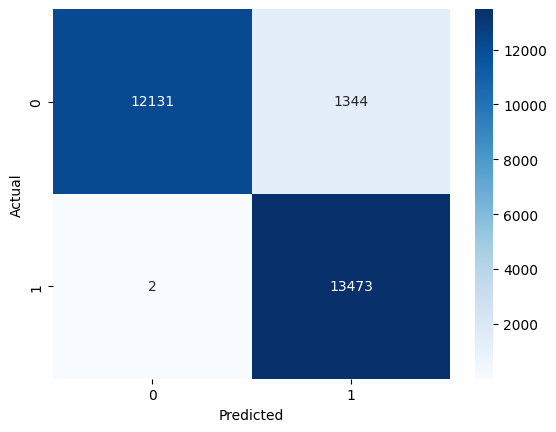

AUC ROC Score: 0.9994


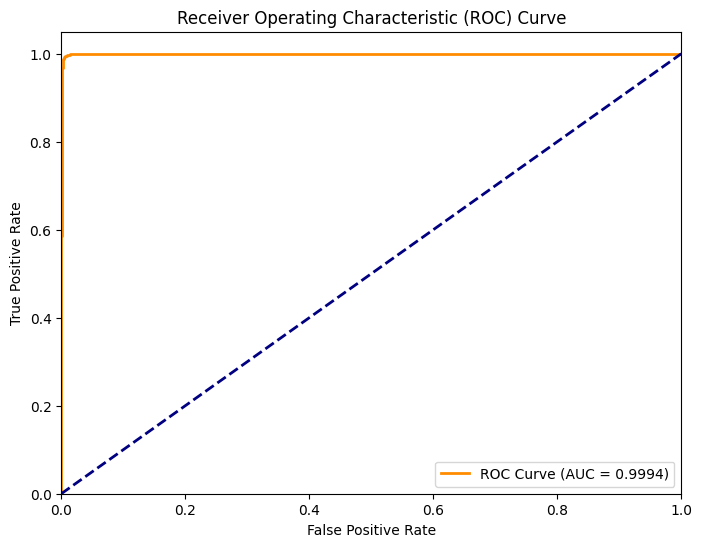

In [ ]:

#Additional Evaluation Metrics: Confusion Matrix, Reachability Matrix, and AUC ROC Curve
# Confusion Matrix
import seaborn as sns
cm = confusion_matrix(gt, pred)
print("Confusion Matrix:")
print(cm)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



# AUC ROC Curve
probs = predictions[all_indices[:, 0], all_indices[:, 1]].cpu().numpy()
fpr, tpr, thresholds = roc_curve(gt, probs)
auc_score = roc_auc_score(gt, probs)
print(f"AUC ROC Score: {auc_score:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()



Predicted Route with Fuzzy Logic Adjustments: [4553572419, 4817412980, 4817412967, 11944102998, 4553572420, 4812743949, 9166327882, 4812743950, 4812743951, 4812743960, 4812743952, 4812743953, 4812743965, 4812743966, 4812743967, 4812743968, 4812743969, 4812743970, 9166327908, 9166327864, 4812743977, 10075130950, 4812743985, 1891049599, 9781149450, 3297684823, 3297684820, 1891049598, 569921291, 569921276, 569921277, 3297684829, 3297684837, 3297684843, 9166327894, 3297684881, 3297734527, 3297734530, 4814703647, 4814703646, 9769578977, 3297684929, 10264441865, 4814703645, 4814703644, 4814703623, 3297684942, 3333960203, 11696885606, 4814703088, 4814703087, 4814703086, 1891049616, 4817729181, 4814703085, 4814703083, 4814703084, 569921305, 4814708037, 11235538695, 4814708036, 4817729179, 9166348716, 10094815788, 11696849688, 4817729214, 569921312, 9765912549]


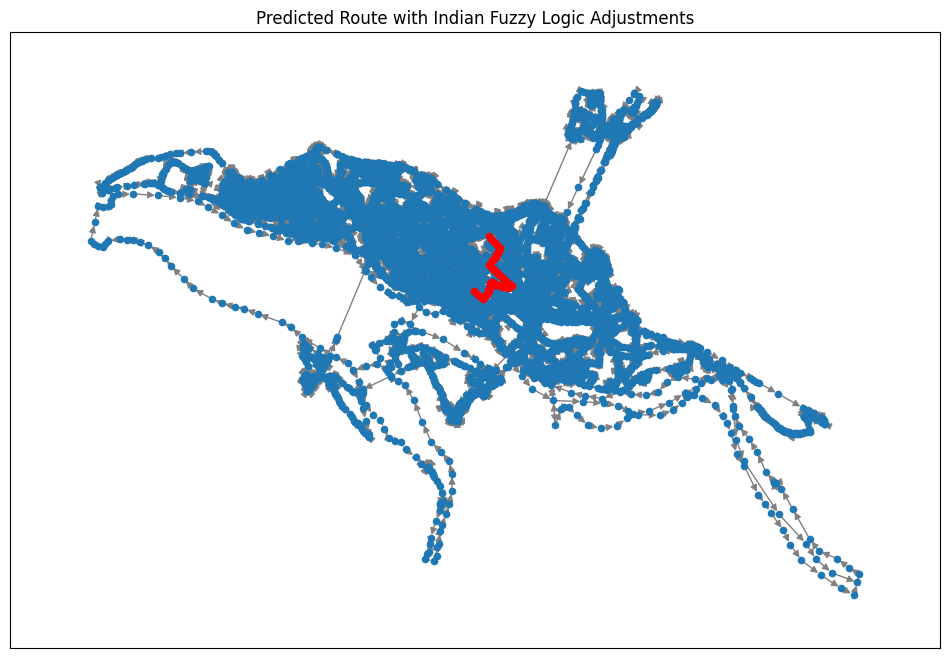

In [ ]:
#Routing with Indian Fuzzy Logic Adjustments
# --- Fuzzy Logic Setup ---
# Assume we have a mapping of some node IDs to points of interest (POIs)
# (In a real scenario, you might extract these from OSM tags or an external database.)
# For demonstration, we simulate that some nodes are near temples, churches, or mosques.
poi_mapping = {
    # Example: node_id: poi_type
    list(G.nodes)[10]: 'temple',
    list(G.nodes)[25]: 'church',
    list(G.nodes)[40]: 'mosque',
    # ... add more as needed.
}

def get_fuzzy_penalty(node_id, season="festive"):
    """
    Returns a penalty factor for nodes near points of interest.
    Higher penalty means increased cost for traversal.
    The factor is dynamic based on the season (e.g., 'festive' increases penalty).
    """
    poi = poi_mapping.get(node_id, None)
    if poi in {"temple", "mosque", "church"}:
        if season == "festive":
            return 2.0  # High penalty during festive season
        else:
            return 1.5  # Moderate penalty during normal conditions
    return 1.0  # No penalty if not a special area

# For dynamic behavior, set the current season. You could make this dynamic based on date.
current_season = "festive"  # or "normal"

# Build a prediction-based weighted graph with fuzzy logic adjustments.
predicted_graph = nx.DiGraph()
epsilon = 1e-6  # to avoid log(0)

for u, v in G.edges:
    if u in node_mapping and v in node_mapping:
        u_idx = node_mapping[u]
        v_idx = node_mapping[v]
        prob = predictions[u_idx, v_idx].item()
        base_cost = -math.log(prob + epsilon)
        # Apply fuzzy penalty: take the average penalty for the source and destination nodes.
        penalty_u = get_fuzzy_penalty(u, season=current_season)
        penalty_v = get_fuzzy_penalty(v, season=current_season)
        penalty_factor = (penalty_u + penalty_v) / 2.0
        adjusted_cost = base_cost * penalty_factor
        predicted_graph.add_edge(u, v, weight=adjusted_cost)

def get_route(source, destination, graph):
    try:
        route = nx.shortest_path(graph, source=source, target=destination, weight='weight')
        return route
    except nx.NetworkXNoPath:
        print(f"No path found between node {source} and node {destination}!")
        return None

# Example usage: choose valid source and destination node IDs.
source_node = list(G.nodes)[0]
destination_node = list(G.nodes)[-1]
route = get_route(source_node, destination_node, predicted_graph)
if route:
    print("Predicted Route with Fuzzy Logic Adjustments:", route)
else:
    print("Route could not be computed.")

# Optional visualization of the route.
pos = {node: (G.nodes[node]['x'], G.nodes[node]['y']) for node in G.nodes}
plt.figure(figsize=(12, 8))
nx.draw_networkx(G, pos=pos, node_size=20, with_labels=False, edge_color='gray')
if route:
    route_edges = list(zip(route, route[1:]))
    nx.draw_networkx_nodes(G, pos=pos, nodelist=route, node_color='red', node_size=20)
    nx.draw_networkx_edges(G, pos=pos, edgelist=route_edges, edge_color='red', width=2)
plt.title("Predicted Route with Indian Fuzzy Logic Adjustments")
plt.show()

In [12]:
import numpy as np

reachability_matrix = np.zeros((len(nodes), len(nodes)))

for i, source in enumerate(nodes):
    if source in predicted_graph_binary:
        reachable_nodes = nx.descendants(predicted_graph_binary, source)
        for target in reachable_nodes:
            j = nodes.index(target)
            reachability_matrix[i][j] = 1

print("Reachability Matrix (Top-Left 10x10 portion):")
print(reachability_matrix[:10, :10])


Reachability Matrix (Top-Left 10x10 portion):
[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]]


===== Reachability Metrics =====
Total Nodes: 10
Reachable Pairs: 89
Total Possible Pairs (excluding self-loops): 90
Reachability Ratio: 0.9889


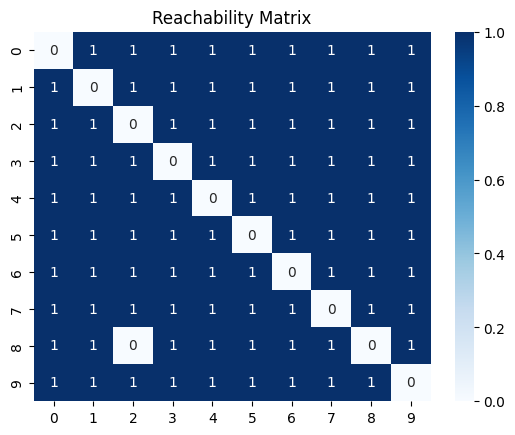

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Correctly define the reachability_matrix as a NumPy array
reachability_matrix = np.array([
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
    [1, 1, 0, 1, 1, 1, 1, 1, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
])

# Calculate metrics
total_nodes = reachability_matrix.shape[0]
total_possible_pairs = total_nodes * (total_nodes - 1)
reachable_pairs = int(np.sum(reachability_matrix))
reachability_ratio = reachable_pairs / total_possible_pairs if total_possible_pairs > 0 else 0

# Print metrics
print("===== Reachability Metrics =====")
print(f"Total Nodes: {total_nodes}")
print(f"Reachable Pairs: {reachable_pairs}")
print(f"Total Possible Pairs (excluding self-loops): {total_possible_pairs}")
print(f"Reachability Ratio: {reachability_ratio:.4f}")

# Plotting the
sns.heatmap(reachability_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Reachability Matrix')
plt.show()

#